In [1]:
import torch
import torchvision
import random
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from torchvision import transforms

In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

Code with data augmentation

In [3]:
%pip install -q timm
from timm.data.auto_augment import rand_augment_transform


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\Aditi P\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [4]:
train_transform=transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.RandomErasing(p=0.5)
])

test_transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.20)),
])

In [5]:
dataset={
    'train': torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=train_transform
    ),
    'test': torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=test_transform
    )
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7692488..2.3557353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4096808..2.7675].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2215865..2.5910294].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1770618..2.7086763].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0219827..1.7282844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2412531..1.5642271].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2933714..

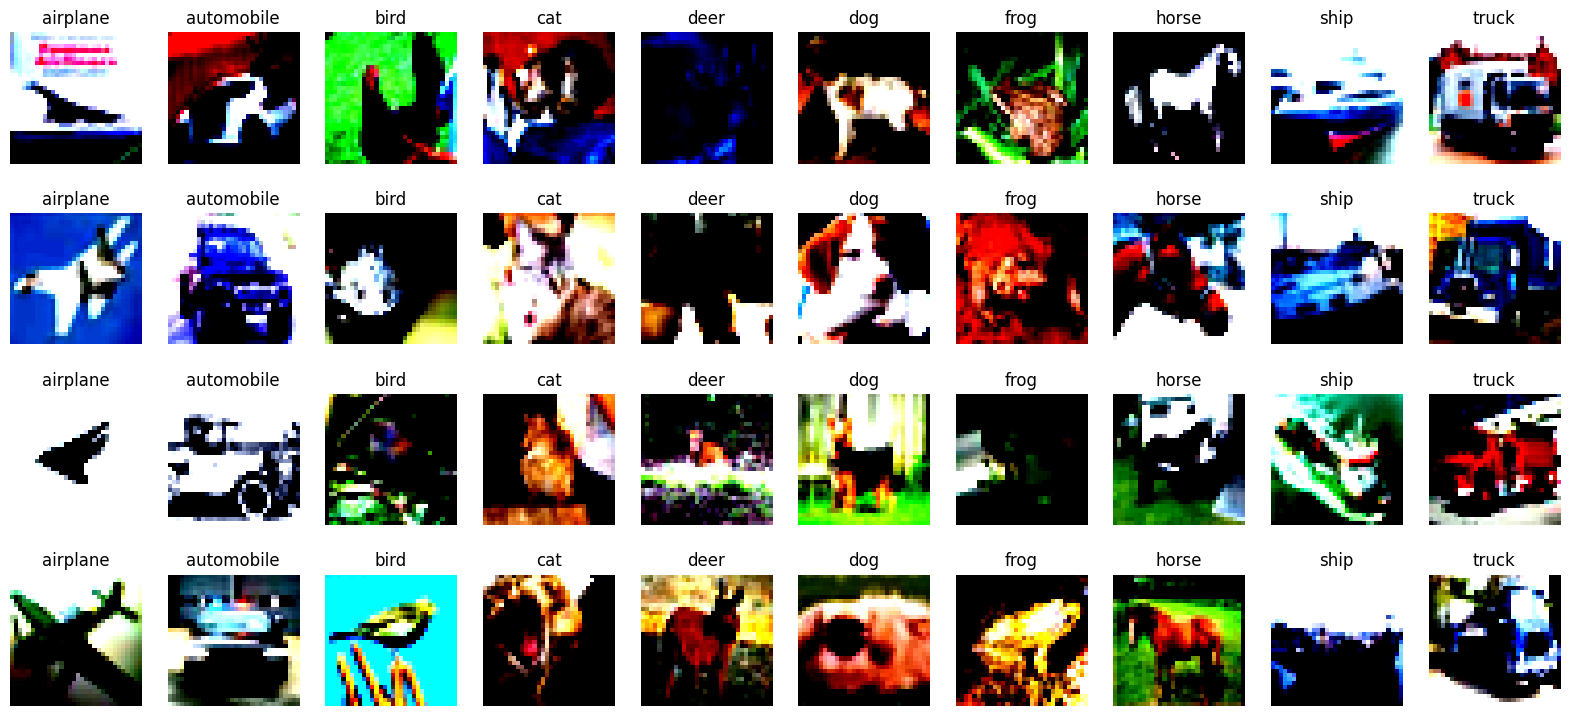

In [6]:
samples = [[] for _ in range(10)]
for image, label in dataset["test"]:
  if len(samples[label]) < 4:
    samples[label].append(image)

plt.figure(figsize=(20, 9))
for index in range(40):
  label = index % 10
  image = samples[label][index // 10]

  # Convert from class index to class name
  label = dataset["test"].classes[label]

  # Visualize the image
  plt.subplot(4, 10, index + 1)
  plt.imshow(image.permute(1, 2, 0)) # Permute the dimensions to (height, width, channels)
  plt.title(label)
  plt.axis("off")
plt.show()

In [7]:
train_dataloader = DataLoader(
    dataset['train'],
    batch_size=128,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
test_dataloader = DataLoader(
    dataset['test'],
    batch_size=128,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"Train samples: {len(dataset['train'])}, Test samples: {len(dataset['test'])}")

Train samples: 50000, Test samples: 10000


In [9]:
%pip install einops
from einops.layers.torch import Rearrange
from torch import Tensor

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 4, emb_size:int=256):
      super().__init__()
      self.patch_size=patch_size
      self.projection=nn.Sequential(
          nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
          Rearrange('b e h w -> b (h w) e')
      )

      self.norm=nn.LayerNorm(emb_size)

    def forward(self, x: Tensor) -> Tensor:
      x=self.projection(x)
      x=self.norm(x)
      return x

sample_datapoint = torch.unsqueeze(dataset["test"][0][0], 0)
print("Initial shape: ", sample_datapoint.shape)
embedding = PatchEmbedding()(sample_datapoint)
print("Patches shape: ", embedding.shape)

  Using cached einops-0.8.1-py3-none-any.whl.metadata (13 kB)
Using cached einops-0.8.1-py3-none-any.whl (64 kB)
Note: you may need to restart the kernel to use updated packages.
Initial shape:  torch.Size([1, 3, 32, 32])
Patches shape:  torch.Size([1, 64, 256])



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\Aditi P\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [10]:
class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.head_dim = dim // n_heads
        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.attn_dropout = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.n_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, B, n_heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Each: (B, n_heads, N, head_dim)

        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = attn.softmax(dim=-1)
        attn = self.attn_dropout(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_dropout(x)

        return x

In [11]:
class PreNorm(nn.Module):
  def __init__(self, dim, fn):
    super().__init__()
    self.norm = nn.LayerNorm(dim)
    self.fn=fn
  def forward(self, x):
    x = self.norm(x)
    return self.fn(x) # Applied normalization only once

In [12]:
class FeedForward(nn.Sequential):
  def __init__(self, dim, hidden_dim, dropout = 0.):
    super().__init__(
        nn.Linear(dim, hidden_dim),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_dim, dim),
        nn.Dropout(dropout)
    )
ff=FeedForward(128,256)
ff(torch.ones((1,5,128))).shape

torch.Size([1, 5, 128])

In [13]:
class DropPath(nn.Module): # Inherit from nn.Module
  def __init__(self, drop_prob=None):
    super().__init__() # Call the parent class constructor
    self.drop_prob=drop_prob
  def forward(self, x):
    if self.drop_prob == 0. or not self.training:
      return x
    keep_prob=1-self.drop_prob
    shape=(x.shape[0],) + (1,) * (x.ndim - 1) # Correct shape for broadcasting
    random_tensor=keep_prob+torch.rand(shape,dtype=x.dtype,device=x.device)
    random_tensor.floor_()
    output=x.div(keep_prob)*random_tensor
    return output

In [14]:
class TransformerBlock(nn.Module):
  def __init__(self, dim, heads, mlp_dim, dropout=0.1, drop_path=0.0):
    super().__init__()
    self.attn=PreNorm(dim, Attention(dim, heads, dropout))
    self.f=PreNorm(dim, FeedForward(dim, mlp_dim, dropout))
    self.drop_path=DropPath(drop_path)
  def forward(self,x):
    x=x+self.drop_path(self.attn(x))
    x=x+self.drop_path(self.f(x))
    return x

In [15]:
from einops import repeat
class VisT(nn.Module):
  def __init__(self, *, image_size, patch_size, emb_dim=384, mlp_dim=1536,
                n_class=10, depth=8, heads=2, channels = 3, dropout = 0.1, drop_path_rate=0.1):
    super().__init__()

    #patching
    self.patch_embedding=PatchEmbedding(channels, patch_size, emb_dim) # Corrected argument order
    num_patches=(image_size[0]//patch_size)*(image_size[1]//patch_size) # Calculate patches for each dimension

    #cls token
    self.pos_embedding=nn.Parameter(torch.randn(1,num_patches+1,emb_dim))
    self.cls_token=nn.Parameter(torch.randn(1,1,emb_dim))
    self.pos_dropout=nn.Dropout(dropout)

    #stochastic depth
    dpr=[x.item() for x in torch.linspace(0,drop_path_rate,depth)]

    #transformer block
    self.layers = nn.ModuleList([])
    for i in range(depth): # Use i for indexing drop_path
        self.layers.append(TransformerBlock(emb_dim, heads, mlp_dim, dropout, dpr[i])) # Pass drop_path

    self.norm=nn.LayerNorm(emb_dim) # Add LayerNorm before the head
    self.head = nn.Linear(emb_dim, n_class)

  def forward(self,img):
    #patch
    x=self.patch_embedding(img)
    b,n,_ = x.shape
    #cls
    cls_tokens=repeat(self.cls_token,'() n d -> b n d',b=b)
    x=torch.cat((cls_tokens,x),dim=1)
    #pos emb
    x+=self.pos_embedding[:,:(n+1)]
    # Changed pos_dropout to be applied to x
    x=self.pos_dropout(x)
    #transblock
    for layer in self.layers:
      x=layer(x)
    #cls final
    x=self.norm(x) # Apply LayerNorm
    cls_token=x[:,0]
    return self.head(cls_token)

In [16]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        n_classes = pred.size(-1)
        log_preds = torch.nn.functional.log_softmax(pred, dim=-1)
        loss = -log_preds.sum(dim=-1).mean()
        nll = torch.nn.functional.nll_loss(log_preds, target, reduction='mean')
        return self.smoothing * (loss / n_classes) + (1 - self.smoothing) * nll


In [17]:
def cosine_sched(optimizer, n_steps, n_train):
  def lr_lambda(curr):
    if curr<n_steps:
      return float(curr)/float(max(1, n_steps))
    return max(0.0, float(n_train-curr)/float(max(1, n_train-n_steps)))
  return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [18]:
from torch.utils.data import random_split

train_split=int(len(dataset["train"])*0.8)
test_split=len(dataset["train"])-train_split

train_dataloader=DataLoader(dataset["train"],batch_size=128,shuffle=True)
test_dataloader=DataLoader(dataset["test"],batch_size=128,shuffle=True)


In [ ]:
def train_epoch(model, loader, criterion, optimizer, device, use_mixup=True):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        if use_mixup:
            images, labels_a, labels_b, lam = mixup_data(images, labels, alpha=1.0)
            outputs = model(images)
            loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        if use_mixup:
            correct += (lam * predicted.eq(labels_a).sum().item() +
                       (1 - lam) * predicted.eq(labels_b).sum().item())
        else:
            correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': f'{running_loss/(pbar.n+1):.3f}',
                         'acc': f'{100.*correct/total:.2f}%'})

    return running_loss / len(loader), 100. * correct / total

In [20]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc='Evaluating', leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({'loss': f'{running_loss/(pbar.n+1):.3f}',
                             'acc': f'{100.*correct/total:.2f}%'})

    return running_loss / len(loader), 100. * correct / total

In [21]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [23]:
import torch.optim as optim
from transformers import get_cosine_schedule_with_warmup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = VisT(
    image_size=(32, 32),
    patch_size=4,
    n_class=10,
    emb_dim=384,
    depth=8,
    heads=8,
    mlp_dim=1536,
    dropout=0.1,
    drop_path_rate=0.1
).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {total_params/1e6:.2f}M")

optimizer = optim.AdamW(
    model.parameters(),
    lr=3e-4,
    weight_decay=0.05,
    betas=(0.9, 0.999)
)

criterion = LabelSmoothingCrossEntropy(smoothing=0.1) # Assuming LabelSmoothingCrossEntropy is defined elsewhere

epochs = 150
warmup_epochs = 5
total_steps = epochs * len(train_dataloader)
warmup_steps = warmup_epochs * len(train_dataloader)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

best_acc = 0.0
train_losses, train_accs = [], []
test_losses, test_accs = [], []

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

    # Train
    train_loss, train_acc = train_epoch(
        model, train_dataloader, criterion, optimizer, device, use_mixup=True # Assuming train_epoch and mixup_data are defined elsewhere
    )

    scheduler.step()

    test_loss, test_acc = evaluate(model, test_dataloader, criterion, device) # Assuming evaluate is defined elsewhere

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.2f}%")

    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'test_acc': test_acc,
        }, 'best_vit_cifar10.pth')
        print(f"✓ Saved best model! Best Acc: {best_acc:.2f}%")

Using device: cuda
Model parameters: 14.24M

STARTING TRAINING

Epoch 1/150
Learning Rate: 0.000000


Train Loss: 2.3889 | Train Acc: 9.48%
Test Loss:  2.3794 | Test Acc:  10.00%
✓ Saved best model! Best Acc: 10.00%

Epoch 2/150
Learning Rate: 0.000000


Train Loss: 2.3374 | Train Acc: 10.14%
Test Loss:  2.2715 | Test Acc:  13.77%
✓ Saved best model! Best Acc: 13.77%

Epoch 3/150
Learning Rate: 0.000000


Train Loss: 2.2904 | Train Acc: 13.11%
Test Loss:  2.2123 | Test Acc:  18.29%
✓ Saved best model! Best Acc: 18.29%

Epoch 4/150
Learning Rate: 0.000000


Train Loss: 2.2618 | Train Acc: 15.31%
Test Loss:  2.1670 | Test Acc:  20.00%
✓ Saved best model! Best Acc: 20.00%

Epoch 5/150
Learning Rate: 0.000001


Train Loss: 2.2355 | Train Acc: 16.62%
Test Loss:  2.1282 | Test Acc:  22.34%
✓ Saved best model! Best Acc: 22.34%

Epoch 6/150
Learning Rate: 0.000001


Train Loss: 2.2167 | Train Acc: 17.63%
Test Loss:  2.1035 | Test Acc:  24.53%
✓ Saved best model! Best Acc: 24.53%

Epoch 7/150
Learning Rate: 0.000001


Train Loss: 2.2038 | Train Acc: 18.44%
Test Loss:  2.0873 | Test Acc:  25.33%
✓ Saved best model! Best Acc: 25.33%

Epoch 8/150
Learning Rate: 0.000001


Train Loss: 2.1956 | Train Acc: 18.95%
Test Loss:  2.0779 | Test Acc:  25.64%
✓ Saved best model! Best Acc: 25.64%

Epoch 9/150
Learning Rate: 0.000001


Train Loss: 2.1926 | Train Acc: 19.24%
Test Loss:  2.0631 | Test Acc:  26.00%
✓ Saved best model! Best Acc: 26.00%

Epoch 10/150
Learning Rate: 0.000001


Train Loss: 2.1791 | Train Acc: 20.04%
Test Loss:  2.0544 | Test Acc:  26.94%
✓ Saved best model! Best Acc: 26.94%

Epoch 11/150
Learning Rate: 0.000002


Train Loss: 2.1733 | Train Acc: 20.50%
Test Loss:  2.0379 | Test Acc:  28.54%
✓ Saved best model! Best Acc: 28.54%

Epoch 12/150
Learning Rate: 0.000002


Train Loss: 2.1673 | Train Acc: 21.04%
Test Loss:  2.0311 | Test Acc:  28.86%
✓ Saved best model! Best Acc: 28.86%

Epoch 13/150
Learning Rate: 0.000002


Train Loss: 2.1601 | Train Acc: 21.82%
Test Loss:  2.0192 | Test Acc:  29.08%
✓ Saved best model! Best Acc: 29.08%

Epoch 14/150
Learning Rate: 0.000002


Train Loss: 2.1491 | Train Acc: 22.36%
Test Loss:  2.0079 | Test Acc:  29.89%
✓ Saved best model! Best Acc: 29.89%

Epoch 15/150
Learning Rate: 0.000002


Train Loss: 2.1470 | Train Acc: 22.73%
Test Loss:  1.9862 | Test Acc:  30.76%
✓ Saved best model! Best Acc: 30.76%

Epoch 16/150
Learning Rate: 0.000002


Train Loss: 2.1353 | Train Acc: 23.36%
Test Loss:  1.9747 | Test Acc:  31.54%
✓ Saved best model! Best Acc: 31.54%

Epoch 17/150
Learning Rate: 0.000002


Train Loss: 2.1270 | Train Acc: 23.98%
Test Loss:  1.9493 | Test Acc:  32.90%
✓ Saved best model! Best Acc: 32.90%

Epoch 18/150
Learning Rate: 0.000003


Train Loss: 2.1100 | Train Acc: 25.14%
Test Loss:  1.9237 | Test Acc:  33.97%
✓ Saved best model! Best Acc: 33.97%

Epoch 19/150
Learning Rate: 0.000003


Train Loss: 2.1028 | Train Acc: 25.18%
Test Loss:  1.9040 | Test Acc:  34.70%
✓ Saved best model! Best Acc: 34.70%

Epoch 20/150
Learning Rate: 0.000003


Train Loss: 2.0924 | Train Acc: 25.83%
Test Loss:  1.8709 | Test Acc:  36.52%
✓ Saved best model! Best Acc: 36.52%

Epoch 21/150
Learning Rate: 0.000003


Train Loss: 2.0792 | Train Acc: 26.56%
Test Loss:  1.8573 | Test Acc:  36.75%
✓ Saved best model! Best Acc: 36.75%

Epoch 22/150
Learning Rate: 0.000003


Train Loss: 2.0676 | Train Acc: 27.33%
Test Loss:  1.8345 | Test Acc:  37.72%
✓ Saved best model! Best Acc: 37.72%

Epoch 23/150
Learning Rate: 0.000003


Train Loss: 2.0647 | Train Acc: 27.65%
Test Loss:  1.8169 | Test Acc:  38.51%
✓ Saved best model! Best Acc: 38.51%

Epoch 24/150
Learning Rate: 0.000004


Train Loss: 2.0566 | Train Acc: 28.08%
Test Loss:  1.8105 | Test Acc:  39.73%
✓ Saved best model! Best Acc: 39.73%

Epoch 25/150
Learning Rate: 0.000004


Train Loss: 2.0425 | Train Acc: 28.99%
Test Loss:  1.7891 | Test Acc:  39.98%
✓ Saved best model! Best Acc: 39.98%

Epoch 26/150
Learning Rate: 0.000004


Train Loss: 2.0340 | Train Acc: 29.58%
Test Loss:  1.7660 | Test Acc:  41.52%
✓ Saved best model! Best Acc: 41.52%

Epoch 27/150
Learning Rate: 0.000004


Train Loss: 2.0251 | Train Acc: 30.11%
Test Loss:  1.7550 | Test Acc:  42.68%
✓ Saved best model! Best Acc: 42.68%

Epoch 28/150
Learning Rate: 0.000004


Train Loss: 2.0212 | Train Acc: 30.28%
Test Loss:  1.7344 | Test Acc:  43.69%
✓ Saved best model! Best Acc: 43.69%

Epoch 29/150
Learning Rate: 0.000004


Train Loss: 2.0161 | Train Acc: 30.81%
Test Loss:  1.7117 | Test Acc:  44.77%
✓ Saved best model! Best Acc: 44.77%

Epoch 30/150
Learning Rate: 0.000004


Train Loss: 2.0011 | Train Acc: 31.54%
Test Loss:  1.7122 | Test Acc:  44.99%
✓ Saved best model! Best Acc: 44.99%

Epoch 31/150
Learning Rate: 0.000005


Train Loss: 1.9877 | Train Acc: 32.35%
Test Loss:  1.6780 | Test Acc:  46.30%
✓ Saved best model! Best Acc: 46.30%

Epoch 32/150
Learning Rate: 0.000005


Train Loss: 1.9878 | Train Acc: 32.27%
Test Loss:  1.6610 | Test Acc:  47.36%
✓ Saved best model! Best Acc: 47.36%

Epoch 33/150
Learning Rate: 0.000005


Train Loss: 1.9750 | Train Acc: 32.95%
Test Loss:  1.6505 | Test Acc:  47.42%
✓ Saved best model! Best Acc: 47.42%

Epoch 34/150
Learning Rate: 0.000005


Train Loss: 1.9726 | Train Acc: 33.26%
Test Loss:  1.6433 | Test Acc:  48.23%
✓ Saved best model! Best Acc: 48.23%

Epoch 35/150
Learning Rate: 0.000005


Train Loss: 1.9678 | Train Acc: 33.72%
Test Loss:  1.6248 | Test Acc:  49.46%
✓ Saved best model! Best Acc: 49.46%

Epoch 36/150
Learning Rate: 0.000005


Train Loss: 1.9627 | Train Acc: 33.88%
Test Loss:  1.6035 | Test Acc:  49.66%
✓ Saved best model! Best Acc: 49.66%

Epoch 37/150
Learning Rate: 0.000006


Train Loss: 1.9473 | Train Acc: 34.81%
Test Loss:  1.6011 | Test Acc:  50.32%
✓ Saved best model! Best Acc: 50.32%

Epoch 38/150
Learning Rate: 0.000006


Train Loss: 1.9478 | Train Acc: 34.83%
Test Loss:  1.6009 | Test Acc:  49.81%

Epoch 39/150
Learning Rate: 0.000006


Train Loss: 1.9468 | Train Acc: 34.98%
Test Loss:  1.5851 | Test Acc:  50.82%
✓ Saved best model! Best Acc: 50.82%

Epoch 40/150
Learning Rate: 0.000006


Train Loss: 1.9452 | Train Acc: 34.95%
Test Loss:  1.5723 | Test Acc:  51.15%
✓ Saved best model! Best Acc: 51.15%

Epoch 41/150
Learning Rate: 0.000006


Train Loss: 1.9273 | Train Acc: 35.82%
Test Loss:  1.5595 | Test Acc:  51.44%
✓ Saved best model! Best Acc: 51.44%

Epoch 42/150
Learning Rate: 0.000006


Train Loss: 1.9264 | Train Acc: 36.22%
Test Loss:  1.5442 | Test Acc:  52.51%
✓ Saved best model! Best Acc: 52.51%

Epoch 43/150
Learning Rate: 0.000006


Train Loss: 1.9214 | Train Acc: 36.36%
Test Loss:  1.5574 | Test Acc:  51.70%

Epoch 44/150
Learning Rate: 0.000007


Train Loss: 1.9183 | Train Acc: 36.33%
Test Loss:  1.5398 | Test Acc:  52.10%

Epoch 45/150
Learning Rate: 0.000007


Train Loss: 1.9058 | Train Acc: 37.19%
Test Loss:  1.5259 | Test Acc:  53.52%
✓ Saved best model! Best Acc: 53.52%

Epoch 46/150
Learning Rate: 0.000007


Train Loss: 1.9245 | Train Acc: 36.19%
Test Loss:  1.5235 | Test Acc:  53.69%
✓ Saved best model! Best Acc: 53.69%

Epoch 47/150
Learning Rate: 0.000007


Train Loss: 1.9202 | Train Acc: 36.10%
Test Loss:  1.5032 | Test Acc:  54.43%
✓ Saved best model! Best Acc: 54.43%

Epoch 48/150
Learning Rate: 0.000007


Train Loss: 1.8942 | Train Acc: 37.83%
Test Loss:  1.4976 | Test Acc:  54.65%
✓ Saved best model! Best Acc: 54.65%

Epoch 49/150
Learning Rate: 0.000007


Train Loss: 1.8888 | Train Acc: 38.14%
Test Loss:  1.4888 | Test Acc:  54.70%
✓ Saved best model! Best Acc: 54.70%

Epoch 50/150
Learning Rate: 0.000008


Train Loss: 1.8981 | Train Acc: 37.64%
Test Loss:  1.4747 | Test Acc:  55.33%
✓ Saved best model! Best Acc: 55.33%

Epoch 51/150
Learning Rate: 0.000008


Train Loss: 1.8902 | Train Acc: 38.06%
Test Loss:  1.4855 | Test Acc:  55.31%

Epoch 52/150
Learning Rate: 0.000008


Train Loss: 1.8921 | Train Acc: 38.14%
Test Loss:  1.4844 | Test Acc:  55.07%

Epoch 53/150
Learning Rate: 0.000008


Train Loss: 1.8816 | Train Acc: 38.44%
Test Loss:  1.4709 | Test Acc:  55.97%
✓ Saved best model! Best Acc: 55.97%

Epoch 54/150
Learning Rate: 0.000008


Train Loss: 1.8640 | Train Acc: 39.58%
Test Loss:  1.4656 | Test Acc:  56.10%
✓ Saved best model! Best Acc: 56.10%

Epoch 55/150
Learning Rate: 0.000008


Train Loss: 1.8597 | Train Acc: 39.82%
Test Loss:  1.4490 | Test Acc:  57.13%
✓ Saved best model! Best Acc: 57.13%

Epoch 56/150
Learning Rate: 0.000008


Train Loss: 1.8619 | Train Acc: 39.66%
Test Loss:  1.4519 | Test Acc:  56.86%

Epoch 57/150
Learning Rate: 0.000009


Train Loss: 1.8572 | Train Acc: 39.71%
Test Loss:  1.4416 | Test Acc:  57.47%
✓ Saved best model! Best Acc: 57.47%

Epoch 58/150
Learning Rate: 0.000009


Train Loss: 1.8539 | Train Acc: 39.97%
Test Loss:  1.4336 | Test Acc:  57.81%
✓ Saved best model! Best Acc: 57.81%

Epoch 59/150
Learning Rate: 0.000009


Train Loss: 1.8412 | Train Acc: 40.60%
Test Loss:  1.4272 | Test Acc:  57.90%
✓ Saved best model! Best Acc: 57.90%

Epoch 60/150
Learning Rate: 0.000009


Train Loss: 1.8543 | Train Acc: 39.99%
Test Loss:  1.4242 | Test Acc:  58.15%
✓ Saved best model! Best Acc: 58.15%

Epoch 61/150
Learning Rate: 0.000009


Train Loss: 1.8445 | Train Acc: 40.46%
Test Loss:  1.4123 | Test Acc:  58.56%
✓ Saved best model! Best Acc: 58.56%

Epoch 62/150
Learning Rate: 0.000009


Train Loss: 1.8275 | Train Acc: 41.50%
Test Loss:  1.4009 | Test Acc:  59.87%
✓ Saved best model! Best Acc: 59.87%

Epoch 63/150
Learning Rate: 0.000010


Train Loss: 1.8507 | Train Acc: 40.31%
Test Loss:  1.4118 | Test Acc:  58.61%

Epoch 64/150
Learning Rate: 0.000010


Train Loss: 1.8444 | Train Acc: 40.71%
Test Loss:  1.3908 | Test Acc:  59.96%
✓ Saved best model! Best Acc: 59.96%

Epoch 65/150
Learning Rate: 0.000010


Train Loss: 1.8323 | Train Acc: 41.17%
Test Loss:  1.3952 | Test Acc:  59.18%

Epoch 66/150
Learning Rate: 0.000010


Train Loss: 1.8370 | Train Acc: 40.82%
Test Loss:  1.3854 | Test Acc:  60.36%
✓ Saved best model! Best Acc: 60.36%

Epoch 67/150
Learning Rate: 0.000010


Train Loss: 1.8267 | Train Acc: 41.33%
Test Loss:  1.3733 | Test Acc:  60.50%
✓ Saved best model! Best Acc: 60.50%

Epoch 68/150
Learning Rate: 0.000010


Train Loss: 1.8270 | Train Acc: 41.52%
Test Loss:  1.3823 | Test Acc:  60.01%

Epoch 69/150
Learning Rate: 0.000010


Train Loss: 1.8327 | Train Acc: 41.09%
Test Loss:  1.3635 | Test Acc:  61.55%
✓ Saved best model! Best Acc: 61.55%

Epoch 70/150
Learning Rate: 0.000011


Train Loss: 1.8043 | Train Acc: 42.75%
Test Loss:  1.3711 | Test Acc:  60.40%

Epoch 71/150
Learning Rate: 0.000011


Train Loss: 1.8083 | Train Acc: 42.68%
Test Loss:  1.3516 | Test Acc:  62.25%
✓ Saved best model! Best Acc: 62.25%

Epoch 72/150
Learning Rate: 0.000011


Train Loss: 1.8061 | Train Acc: 42.47%
Test Loss:  1.3496 | Test Acc:  61.86%

Epoch 73/150
Learning Rate: 0.000011


Train Loss: 1.8114 | Train Acc: 42.49%
Test Loss:  1.3562 | Test Acc:  61.43%

Epoch 74/150
Learning Rate: 0.000011


Train Loss: 1.7989 | Train Acc: 43.18%
Test Loss:  1.3487 | Test Acc:  61.55%

Epoch 75/150
Learning Rate: 0.000011


Train Loss: 1.7969 | Train Acc: 43.39%
Test Loss:  1.3365 | Test Acc:  62.35%
✓ Saved best model! Best Acc: 62.35%

Epoch 76/150
Learning Rate: 0.000012


Train Loss: 1.7970 | Train Acc: 43.05%
Test Loss:  1.3428 | Test Acc:  61.65%

Epoch 77/150
Learning Rate: 0.000012


Train Loss: 1.8071 | Train Acc: 42.44%
Test Loss:  1.3424 | Test Acc:  61.74%

Epoch 78/150
Learning Rate: 0.000012


Train Loss: 1.8068 | Train Acc: 42.56%
Test Loss:  1.3302 | Test Acc:  62.22%

Epoch 79/150
Learning Rate: 0.000012


Train Loss: 1.7807 | Train Acc: 43.94%
Test Loss:  1.3219 | Test Acc:  63.18%
✓ Saved best model! Best Acc: 63.18%

Epoch 80/150
Learning Rate: 0.000012


Train Loss: 1.7927 | Train Acc: 43.40%
Test Loss:  1.3328 | Test Acc:  62.45%

Epoch 81/150
Learning Rate: 0.000012


Train Loss: 1.7972 | Train Acc: 43.35%
Test Loss:  1.3204 | Test Acc:  62.51%

Epoch 82/150
Learning Rate: 0.000012


Train Loss: 1.7802 | Train Acc: 43.92%
Test Loss:  1.3162 | Test Acc:  62.82%

Epoch 83/150
Learning Rate: 0.000013


Train Loss: 1.7743 | Train Acc: 44.47%
Test Loss:  1.3098 | Test Acc:  63.48%
✓ Saved best model! Best Acc: 63.48%

Epoch 84/150
Learning Rate: 0.000013


Train Loss: 1.7769 | Train Acc: 44.24%
Test Loss:  1.3209 | Test Acc:  63.04%

Epoch 85/150
Learning Rate: 0.000013


Train Loss: 1.7659 | Train Acc: 44.56%
Test Loss:  1.2957 | Test Acc:  63.95%
✓ Saved best model! Best Acc: 63.95%

Epoch 86/150
Learning Rate: 0.000013


Train Loss: 1.7775 | Train Acc: 44.33%
Test Loss:  1.3047 | Test Acc:  63.73%

Epoch 87/150
Learning Rate: 0.000013


Train Loss: 1.7787 | Train Acc: 44.32%
Test Loss:  1.2842 | Test Acc:  64.34%
✓ Saved best model! Best Acc: 64.34%

Epoch 88/150
Learning Rate: 0.000013


Train Loss: 1.7790 | Train Acc: 44.22%
Test Loss:  1.2807 | Test Acc:  64.59%
✓ Saved best model! Best Acc: 64.59%

Epoch 89/150
Learning Rate: 0.000014


Train Loss: 1.7656 | Train Acc: 44.96%
Test Loss:  1.2895 | Test Acc:  64.61%
✓ Saved best model! Best Acc: 64.61%

Epoch 90/150
Learning Rate: 0.000014


Train Loss: 1.7646 | Train Acc: 44.84%
Test Loss:  1.2760 | Test Acc:  64.94%
✓ Saved best model! Best Acc: 64.94%

Epoch 91/150
Learning Rate: 0.000014


Train Loss: 1.7743 | Train Acc: 44.52%
Test Loss:  1.2899 | Test Acc:  64.51%

Epoch 92/150
Learning Rate: 0.000014


Train Loss: 1.7602 | Train Acc: 45.07%
Test Loss:  1.2637 | Test Acc:  65.77%
✓ Saved best model! Best Acc: 65.77%

Epoch 93/150
Learning Rate: 0.000014


Train Loss: 1.7507 | Train Acc: 45.89%
Test Loss:  1.2569 | Test Acc:  65.95%
✓ Saved best model! Best Acc: 65.95%

Epoch 94/150
Learning Rate: 0.000014


Train Loss: 1.7572 | Train Acc: 45.33%
Test Loss:  1.2527 | Test Acc:  66.10%
✓ Saved best model! Best Acc: 66.10%

Epoch 95/150
Learning Rate: 0.000014


Train Loss: 1.7656 | Train Acc: 44.86%
Test Loss:  1.2749 | Test Acc:  65.12%

Epoch 96/150
Learning Rate: 0.000015


Train Loss: 1.7617 | Train Acc: 45.14%
Test Loss:  1.2509 | Test Acc:  66.70%
✓ Saved best model! Best Acc: 66.70%

Epoch 97/150
Learning Rate: 0.000015


Train Loss: 1.7588 | Train Acc: 45.38%
Test Loss:  1.2653 | Test Acc:  66.23%

Epoch 98/150
Learning Rate: 0.000015


Train Loss: 1.7434 | Train Acc: 46.00%
Test Loss:  1.2585 | Test Acc:  66.25%

Epoch 99/150
Learning Rate: 0.000015


Train Loss: 1.7420 | Train Acc: 46.11%
Test Loss:  1.2479 | Test Acc:  66.35%

Epoch 100/150
Learning Rate: 0.000015


Train Loss: 1.7388 | Train Acc: 46.24%
Test Loss:  1.2475 | Test Acc:  65.89%

Epoch 101/150
Learning Rate: 0.000015


Train Loss: 1.7479 | Train Acc: 45.84%
Test Loss:  1.2497 | Test Acc:  65.78%

Epoch 102/150
Learning Rate: 0.000015


Train Loss: 1.7490 | Train Acc: 45.77%
Test Loss:  1.2391 | Test Acc:  66.61%

Epoch 103/150
Learning Rate: 0.000016


Train Loss: 1.7320 | Train Acc: 46.63%
Test Loss:  1.2344 | Test Acc:  67.34%
✓ Saved best model! Best Acc: 67.34%

Epoch 104/150
Learning Rate: 0.000016


Train Loss: 1.7306 | Train Acc: 46.99%
Test Loss:  1.2301 | Test Acc:  67.38%
✓ Saved best model! Best Acc: 67.38%

Epoch 105/150
Learning Rate: 0.000016


Train Loss: 1.7303 | Train Acc: 46.86%
Test Loss:  1.2241 | Test Acc:  67.64%
✓ Saved best model! Best Acc: 67.64%

Epoch 106/150
Learning Rate: 0.000016


Train Loss: 1.7329 | Train Acc: 46.45%
Test Loss:  1.2193 | Test Acc:  67.41%

Epoch 107/150
Learning Rate: 0.000016


Train Loss: 1.7299 | Train Acc: 47.00%
Test Loss:  1.2221 | Test Acc:  67.59%

Epoch 108/150
Learning Rate: 0.000016


Train Loss: 1.7462 | Train Acc: 45.93%
Test Loss:  1.2195 | Test Acc:  68.03%
✓ Saved best model! Best Acc: 68.03%

Epoch 109/150
Learning Rate: 0.000017


Train Loss: 1.7133 | Train Acc: 47.60%
Test Loss:  1.2090 | Test Acc:  68.42%
✓ Saved best model! Best Acc: 68.42%

Epoch 110/150
Learning Rate: 0.000017


Train Loss: 1.7134 | Train Acc: 47.85%
Test Loss:  1.2086 | Test Acc:  68.50%
✓ Saved best model! Best Acc: 68.50%

Epoch 111/150
Learning Rate: 0.000017


Train Loss: 1.7195 | Train Acc: 47.48%
Test Loss:  1.2103 | Test Acc:  67.99%

Epoch 112/150
Learning Rate: 0.000017


Train Loss: 1.7153 | Train Acc: 47.55%
Test Loss:  1.2087 | Test Acc:  68.26%

Epoch 113/150
Learning Rate: 0.000017


Train Loss: 1.7016 | Train Acc: 48.39%
Test Loss:  1.1981 | Test Acc:  68.80%
✓ Saved best model! Best Acc: 68.80%

Epoch 114/150
Learning Rate: 0.000017


Train Loss: 1.7154 | Train Acc: 47.51%
Test Loss:  1.2025 | Test Acc:  68.64%

Epoch 115/150
Learning Rate: 0.000017


Train Loss: 1.7251 | Train Acc: 46.94%
Test Loss:  1.2017 | Test Acc:  68.63%

Epoch 116/150
Learning Rate: 0.000018


Train Loss: 1.7261 | Train Acc: 47.16%
Test Loss:  1.2037 | Test Acc:  68.69%

Epoch 117/150
Learning Rate: 0.000018


Train Loss: 1.7036 | Train Acc: 48.20%
Test Loss:  1.1979 | Test Acc:  68.95%
✓ Saved best model! Best Acc: 68.95%

Epoch 118/150
Learning Rate: 0.000018


Train Loss: 1.7110 | Train Acc: 47.79%
Test Loss:  1.2091 | Test Acc:  68.06%

Epoch 119/150
Learning Rate: 0.000018


Train Loss: 1.6897 | Train Acc: 48.80%
Test Loss:  1.2002 | Test Acc:  68.71%

Epoch 120/150
Learning Rate: 0.000018


Train Loss: 1.7152 | Train Acc: 47.57%
Test Loss:  1.1887 | Test Acc:  69.12%
✓ Saved best model! Best Acc: 69.12%

Epoch 121/150
Learning Rate: 0.000018


Train Loss: 1.7082 | Train Acc: 48.32%
Test Loss:  1.1970 | Test Acc:  68.88%

Epoch 122/150
Learning Rate: 0.000019


Train Loss: 1.6820 | Train Acc: 49.46%
Test Loss:  1.1894 | Test Acc:  69.36%
✓ Saved best model! Best Acc: 69.36%

Epoch 123/150
Learning Rate: 0.000019


Train Loss: 1.6851 | Train Acc: 49.38%
Test Loss:  1.1741 | Test Acc:  70.11%
✓ Saved best model! Best Acc: 70.11%

Epoch 124/150
Learning Rate: 0.000019


Train Loss: 1.6992 | Train Acc: 48.57%
Test Loss:  1.1636 | Test Acc:  70.42%
✓ Saved best model! Best Acc: 70.42%

Epoch 125/150
Learning Rate: 0.000019


Train Loss: 1.7011 | Train Acc: 48.48%
Test Loss:  1.1893 | Test Acc:  69.63%

Epoch 126/150
Learning Rate: 0.000019


Train Loss: 1.6827 | Train Acc: 49.40%
Test Loss:  1.1704 | Test Acc:  70.64%
✓ Saved best model! Best Acc: 70.64%

Epoch 127/150
Learning Rate: 0.000019


Train Loss: 1.6941 | Train Acc: 48.96%
Test Loss:  1.1624 | Test Acc:  71.06%
✓ Saved best model! Best Acc: 71.06%

Epoch 128/150
Learning Rate: 0.000019


Train Loss: 1.7025 | Train Acc: 48.55%
Test Loss:  1.1803 | Test Acc:  69.78%

Epoch 129/150
Learning Rate: 0.000020


Train Loss: 1.6847 | Train Acc: 49.28%
Test Loss:  1.1787 | Test Acc:  70.05%

Epoch 130/150
Learning Rate: 0.000020


Train Loss: 1.6670 | Train Acc: 49.83%
Test Loss:  1.1623 | Test Acc:  70.98%

Epoch 131/150
Learning Rate: 0.000020


Train Loss: 1.6692 | Train Acc: 50.28%
Test Loss:  1.1639 | Test Acc:  70.60%

Epoch 132/150
Learning Rate: 0.000020


Train Loss: 1.6938 | Train Acc: 48.90%
Test Loss:  1.1771 | Test Acc:  70.25%

Epoch 133/150
Learning Rate: 0.000020


Train Loss: 1.6650 | Train Acc: 50.51%
Test Loss:  1.1553 | Test Acc:  71.19%
✓ Saved best model! Best Acc: 71.19%

Epoch 134/150
Learning Rate: 0.000020


Train Loss: 1.6779 | Train Acc: 49.61%
Test Loss:  1.1538 | Test Acc:  71.73%
✓ Saved best model! Best Acc: 71.73%

Epoch 135/150
Learning Rate: 0.000021


Train Loss: 1.6831 | Train Acc: 49.47%
Test Loss:  1.1512 | Test Acc:  71.65%

Epoch 136/150
Learning Rate: 0.000021


Train Loss: 1.6598 | Train Acc: 50.51%
Test Loss:  1.1331 | Test Acc:  72.16%
✓ Saved best model! Best Acc: 72.16%

Epoch 137/150
Learning Rate: 0.000021


Train Loss: 1.6867 | Train Acc: 49.39%
Test Loss:  1.1465 | Test Acc:  71.22%

Epoch 138/150
Learning Rate: 0.000021


Train Loss: 1.6920 | Train Acc: 48.87%
Test Loss:  1.1427 | Test Acc:  71.86%

Epoch 139/150
Learning Rate: 0.000021


Train Loss: 1.6654 | Train Acc: 50.25%
Test Loss:  1.1627 | Test Acc:  71.06%

Epoch 140/150
Learning Rate: 0.000021


Train Loss: 1.6429 | Train Acc: 51.26%
Test Loss:  1.1314 | Test Acc:  72.01%

Epoch 141/150
Learning Rate: 0.000021


Train Loss: 1.6635 | Train Acc: 50.44%
Test Loss:  1.1248 | Test Acc:  72.80%
✓ Saved best model! Best Acc: 72.80%

Epoch 142/150
Learning Rate: 0.000022


Train Loss: 1.6692 | Train Acc: 50.16%
Test Loss:  1.1261 | Test Acc:  72.61%

Epoch 143/150
Learning Rate: 0.000022


Train Loss: 1.6768 | Train Acc: 49.64%
Test Loss:  1.1174 | Test Acc:  72.95%
✓ Saved best model! Best Acc: 72.95%

Epoch 144/150
Learning Rate: 0.000022


Train Loss: 1.6668 | Train Acc: 50.43%
Test Loss:  1.1236 | Test Acc:  72.53%

Epoch 145/150
Learning Rate: 0.000022


KeyboardInterrupt: 